In [1]:
%matplotlib inline

In [2]:
import arrow
from netCDF4 import Dataset
import glob
import os
import pandas as pd
from cdftools.local_index import LocalIndex
import json
import matplotlib.dates as mdates
import requests
import numpy as np
from cdftools import profiles as cfprofiles
from cdftools import dap

if not os.path.exists('/tmp/hycom'):
    os.makedirs('/tmp/hycom')

# Remove indexes, and start fresh

for stupidfile in glob.glob('/tmp/hycom/time.*'):
    os.remove(stupidfile)
for stupidfile in glob.glob('/tmp/hycom/space.*'):
    os.remove(stupidfile)

# I saved the thredds catalog URLs so I wouldn't have to crawl the catalog each time.
with open('data/urls.json', 'r') as f:
    urls = json.load(f)

# Build a spatial and temporal index of each netCDF file
index = LocalIndex('/tmp/hycom/time', '/tmp/hycom/space')
index.build_index(urls)

ERROR:cdftools:Failed to index: http://data.oceansmap.com/thredds/dodsC/EDS/HYCOM_3D_R1/hycom_3d_r1_2016062221.nc
Traceback (most recent call last):
  File "/Users/lcampbell/Documents/Dev/code/cdftools/cdftools/local_index.py", line 24, in build_index
    self.index_nc(path)
  File "/Users/lcampbell/Documents/Dev/code/cdftools/cdftools/local_index.py", line 29, in index_nc
    with Dataset(path, 'r') as nc:
  File "netCDF4/_netCDF4.pyx", line 1795, in netCDF4._netCDF4.Dataset.__init__ (netCDF4/_netCDF4.c:12271)
RuntimeError: NetCDF: DAP server error
ERROR:cdftools:Failed to index: http://data.oceansmap.com/thredds/dodsC/EDS/HYCOM_3D_R1/hycom_3d_r1_2016061712.nc
Traceback (most recent call last):
  File "/Users/lcampbell/Documents/Dev/code/cdftools/cdftools/local_index.py", line 24, in build_index
    self.index_nc(path)
  File "/Users/lcampbell/Documents/Dev/code/cdftools/cdftools/local_index.py", line 29, in index_nc
    with Dataset(path, 'r') as nc:
  File "netCDF4/_netCDF4.pyx", li

In [3]:
def get_profile(row, depthmax=None):
    '''
    Returns a numpy array of profile data and the timestamp of the profile
    
    :param row: The Pandas Row containing time, latitude and longitude
    :param depthmax: The INDEX of the depth dimension to limit, default is None
    '''
    ncpath = index.get_nearest(row.time)
    lat = float(row.latitude)
    lon = float(row.longitude)
    dslice = slice(0, depthmax)
    with Dataset(ncpath) as nc:
        i, j = dap.get_point_index(nc, lon, lat)
        t_i, actual = dap.get_index(nc, arrow.get(row.name))
        profile = nc.variables['water_temp'][t_i, dslice, i, j]
        return profile, actual

In [4]:
# Get the trajectory

# Unfortunately ERDDAP returns two rows in the CSV, so I need to rip out row 2
response = requests.get('http://data.ioos.us/gliders/erddap/tabledap/ru28-20160714T1410.csv?time,latitude,longitude')
lines = response.content.split('\n')
body = '\n'.join([lines[0]] + lines[2:])
from cStringIO import StringIO
buf = StringIO(body)

In [5]:
table = pd.read_csv(buf)

In [6]:
# Build the profiles
profiles = []
dates = []
for idx, row in table.iterrows():
    profile, dt = get_profile(row, 10)
    profiles.append(profile)
    dates.append(dt)

In [7]:
len(profiles)

1570

In [8]:
Z = np.vstack(profiles)

In [9]:
X = np.ones_like(Z, dtype=np.object)
for i, timestamp in enumerate(mdates.date2num(dates)):
    X[i, :] = timestamp

In [10]:
ncpath = index.get_nearest(table.iloc[0].time)

with Dataset(ncpath) as nc:
    depths = nc.variables['depth'][:10]
    print nc.variables['depth'].units

meter


In [11]:
Y = np.ones_like(Z)
for i, ones in enumerate(Y):
    Y[i] = depths

/Users/lcampbell/.virtualenvs/work/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


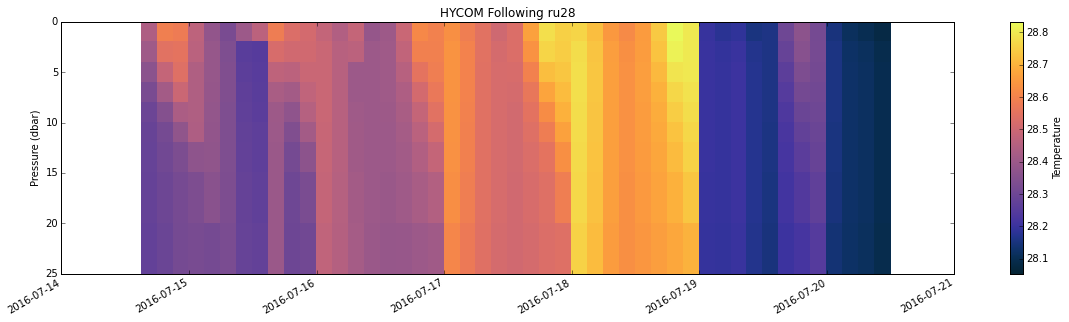

In [12]:
fig = cfprofiles.generate_profile_plot(X, Y, Z, cfprofiles.PARAMETERS['temperature']['cmap'], 'HYCOM Following ru28')
fig.set_size_inches(20, 5)
fig.savefig('/Users/lcampbell/Desktop/hycom-ru28.png', dpi=100)